Let's import everything at the begining (My past as a C/C++ programmer betrays me)

In [1]:
import data_augmentation_toolkit as data_aug
import numpy as np
import pylab as plt
import pandas as pd
import pickle
import random
import math
import os

from scipy.misc import imread
from random import shuffle

%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

Using TensorFlow backend.


Create an initial model. I don't agree to much with the idea of doing subsampling (stride>1) in the convolutional layers, as I read in multiple places that is more destructive than using a pooling layer after the convolutional one without subsampling, but let's give it an oportunity.

### Model definition

In [3]:
def get_model_nvidia(image_shape):
    """
    End to End Learning for Self-Driving Cars
    http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf
    
    No info is provided for activations, hence I choose RELU
    """
    

    '''
    def normalize(x, a, b):
        x = x.astype(np.float32)
        return a + (x-x.min())*(b-a)/(x.max() - x.min())
    '''
    
    model = Sequential()
    
    # Use a lambda layer to normalize the input data
    #model.add(Lambda(lambda x: normalize(x, 0, 1), input_shape=image_shape, output_shape=image_shape))
    # Removed Lambda layer. Seems to add more troubles than it helps.
    model.add(Convolution2D(nb_filter=24, nb_row=5, nb_col=5, border_mode='valid', subsample=(2,2), input_shape=image_shape))
    model.add(Activation('relu'))
    model.add(Convolution2D(nb_filter=36, nb_row=5, nb_col=5, border_mode='valid', subsample=(2,2)))
    model.add(Activation('relu'))
    model.add(Convolution2D(nb_filter=48, nb_row=5, nb_col=5, border_mode='valid', subsample=(2,2)))
    model.add(Activation('relu'))
    model.add(Convolution2D(nb_filter=64, nb_row=3, nb_col=3, border_mode='valid'))
    model.add(Activation('relu'))
    model.add(Convolution2D(nb_filter=64, nb_row=3, nb_col=3, border_mode='valid'))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(1164))
    model.add(Activation('relu'))     
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dense(50))
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('relu'))
    model.add(Dense(1))
    
    return model

Maybe I want to play with optimizers later, but for the moment, a standard adam should be more than fine

In [4]:
def get_optimizer():
    return Adam()

### Training options

In [5]:
path2models = "./models/model.{epoch:02d}-{val_loss:.3f}.h5"

os.makedirs('./models', exist_ok=True)


def train_model(train_gen, val_gen, batch_size, epochs, model, \
                optimizer=None, limit_train=None, limit_val=None):
    
    if optimizer:
        model.compile(optimizer=optimizer, loss="mse")
    else:
        model.compile(optimizer="adam", loss="mse") # This is a nice optimizer to be left as default
        
    # Callbacks
    reduce_lr_on_plateau = ReduceLROnPlateau(factor=0.5, patience=3, cooldown=3, min_lr=1e-5)
    checkpoint = ModelCheckpoint(filepath=path2models)
    early_stopping = EarlyStopping(min_delta=1e-3, patience=7)
    
    ls_callbacks = [checkpoint, reduce_lr_on_plateau, early_stopping]
    
        
    samples_per_epoch = limit_train if limit_train else batch_size*math.ceil(train_gen.get_epoch_size()/batch_size)
    nb_epoch = epochs
    nb_val_samples = limit_val if limit_val else val_gen.get_epoch_size()
    history = model.fit_generator(train_gen, samples_per_epoch, nb_epoch, \
                                  nb_val_samples=nb_val_samples, validation_data=val_gen, callbacks=ls_callbacks)
    
    return history, model

### Generator definition

In [21]:
# Prepare the data with a python generator so we can do data augmentation on the fly

class My_dataset_gen():
    """
    To be strict, My_dataset_gen is not a real generator (does not call yield) but an iterator
    """
    def __init__(self, 
                 path2csv,
                 path2prob_tools,
                 batch_size,
                 camera_effect=False,
                 training=True):
        
        self.batch_size = batch_size
        
        # Load the CSV
        df = pd.read_csv(path2csv)
        self.dataset = df.to_dict(orient='records') # This is a list of dict
        
        self.position = 0
        self.size_epoch = len(self.dataset)
        self.training = training
        
        self.max_perturbation = 0.02 # This is a really small perturbation that will be added to the steering angle.
        # Not enough to damage the behaviour of the model, but enough to add some variety.
        
        self.camera = {'left_camera': +0.2, 'right_camera': -0.2, 'center_camera': 0} # Pseudo camera position 
        # and corresponding steering angle's offsets
        self.pseudo_shift_value = 50
        self.camera_effect = camera_effect
        
        # Angle-preserving transformations
        self.angle_preserving = [data_aug.salt_and_pepper, data_aug.bilateral_filter, data_aug.speckle_noise, \
                                 data_aug.random_light, data_aug.random_shadow, data_aug.histogram_equalization, \
                                 data_aug.identity]
        # Load probability tools
        prob_tools = pickle.load(open(path2prob_tools, 'rb'))
        self.bins = prob_tools['bins']
        self.converter = prob_tools['converter']
        
    def __iter__(self):
        return self
    
    def __next__(self):

        number_of_samples = 0
        X_l = list()
        Y_l = list()
        
        while number_of_samples < self.batch_size:
            if self.position == self.size_epoch:
                shuffle(self.dataset)
                self.position = 0
                
            sample = self.dataset[self.position]
            
            image = imread(sample['Updated image path'])
            image = self._vertical_crop(image)
            angle = sample['Steering angle']*random.uniform(-1, 1)*self.max_perturbation
            
            if self.training:
                image, angle = self._random_transform(image, angle)
                prob_appearance = self._angle2probability(angle) # The random transformation can change angle's bin
                rand_val = random.random()
            
                if rand_val <= 1-prob_appearance: # This way we eliminate biases toward more frequent values
                # E.g. prob_appearance = 0.25. This means it appears  only 25% of the times in the dataset
                # but I want to balance it, so I do 1-0.25= 0.75. Comparing with a random value between 0 and 1, this sample 
                # will be used (with data augmentation techniques) the 75% of the times. Category samples with a high 
                # prob_appearance will be more likely rejected, but because of there are more samples of that 
                # category doesn't matter. On average all categories should be balanced.
                    
                    image = self._normalize(image)

                    X_l.append(image)
                    Y_l.append(angle)
                    number_of_samples += 1
                    
            else:                    
                image = self._normalize(image)
                
                if self.camera_effect:
                    image = data_aug.pseudo_shift(image, 'center_camera', self.pseudo_shift_value)
                
                X_l.append(image)
                Y_l.append(angle)
                number_of_samples += 1
                
                
            self.position += 1
            
        #Tracer()()
        X = np.array(X_l) # Current shape follows tf dim_ordering: (samples, height, width, channels)
        Y = np.array(Y_l)
        
        return (X,Y)
            
    
    def _normalize(self, x, a=0, b=1):
        x = x.astype(np.float32)
        return a + (x-x.min())*(b-a)/(x.max() - x.min())
    
    def _vertical_crop(self, x):
        """
        Input shape (160, 320, 3)
        Ouput shape (90, 320, 3)
        """
        return x[60:150, :] # See Explore dataset + Experimental setup.ipynb 
        # Original x[60:150, :], updated to x[60:150, :] seems to be a better option in order to remove remaining clutter.

    def _random_transform(self, image, angle):
        # We are always going to choose a random angle-preserving transformation (the identity is included) and
        # after that a non-angle-preserving transformation the half of the time.
        
        # Angle-preserving transformation
        image = random.choice(self.angle_preserving)(image)
        
        # Non-angle-preserving transformation
        
        if random.random() >= 0.5:
            image = data_aug.horizontal_flipping(image)
            angle = -angle
        
        if self.camera_effect:
            # With the next 3 lines we can add more recovery data simulating different camera positions
            camera_position = random.choice(list(self.camera.keys()))
            image = data_aug.pseudo_shift(image, camera_position, self.pseudo_shift_value)
            angle += self.camera[camera_position]
            
        return image, angle
    
    def _angle2probability(self, angle):
        bi = int(np.digitize(angle, self.bins))
        if bi == 21: # to avoid edges issues
            bi = 20
        return self.converter[bi]
    
    def get_original_image_shape(self):
        temp = imread(self.dataset[0]['Updated image path'])
        return temp.shape

    def get_input_image_shape(self):
        """
        This function returns the shape of the transformed image, i.e. the one that will be the input to the net.
        """
        temp = imread(self.dataset[0]['Updated image path'])
        
        shape = list(self._vertical_crop(temp).shape)
        
        if self.camera_effect:
            shape[1] -= self.pseudo_shift_value # Because of data_aug.pseudo_shift
        
        return tuple(shape)
    
        
    def get_epoch_size(self):
        return self.size_epoch

# Let's perform a quick test to see if all the pieces work

In [34]:
path2dataset = "/mnt/Behavioral-Cloning-Dataset/"
path2csv_training = path2dataset + "driving_log_training.csv"
path2csv_validation = path2dataset + "driving_log_validation.csv"
path2prob_tools = path2dataset + "prob_tools.pkl"

batch_size = 2
epochs = 2
limit_train = 10
limit_val = 10

train_gen = My_dataset_gen(path2csv_training, path2prob_tools, batch_size, camera_effect=True)
val_gen = My_dataset_gen(path2csv_validation, path2prob_tools, batch_size, camera_effect=True, training=True)

In [35]:
# Let's visualize some statistics about the dataset

print("Number of training samples: %d" % (train_gen.get_epoch_size()))
print("Number of validation samples: %d" % (val_gen.get_epoch_size()))
print("Shape of the original images: ", train_gen.get_original_image_shape())
print("Shape of the processed images: ", train_gen.get_input_image_shape())

Number of training samples: 39746
Number of validation samples: 9937
Shape of the original images:  (160, 320, 3)
Shape of the processed images:  (90, 270, 3)


In [36]:
model = get_model_nvidia(train_gen.get_input_image_shape())
optimizer = get_optimizer()

# Just have a look at our model before training:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_21 (Convolution2D) (None, 43, 133, 24)   1824        convolution2d_input_5[0][0]      
____________________________________________________________________________________________________
activation_37 (Activation)       (None, 43, 133, 24)   0           convolution2d_21[0][0]           
____________________________________________________________________________________________________
convolution2d_22 (Convolution2D) (None, 20, 65, 36)    21636       activation_37[0][0]              
____________________________________________________________________________________________________
activation_38 (Activation)       (None, 20, 65, 36)    0           convolution2d_22[0][0]           
___________________________________________________________________________________________

In [37]:
history, model = train_model(train_gen, val_gen, batch_size, epochs, model, optimizer, limit_train, limit_val)
# There is no need to save the model. It's already saved by the callbacks provided in fit_generator

Epoch 1/2
10/10 [==============================] - 1s - loss: 0.0461 - val_loss: 0.0393
Epoch 2/2
10/10 [==============================] - 0s - loss: 0.0305 - val_loss: 0.0299


In [38]:
def plot_loss_vs_epochs(training_loss, validation_loss):
    plt.plot(range(1,len(training_loss)+1), training_loss, 'b')
    plt.xticks(range(1,len(training_loss)+1))
    plt.hold(True)
    plt.plot(range(1,len(training_loss)+1), validation_loss, 'g')
    plt.hold(False)
    _ = plt.legend(("Training", "Validation"), loc='upper right')
    _ = plt.ylabel("Loss")
    _ = plt.xlabel("Epochs")

/home/ubuntu/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:4: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/home/ubuntu/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/ubuntu/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")
/home/ubuntu/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:6: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elem

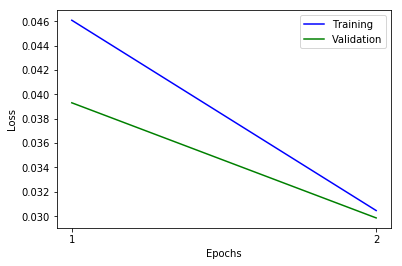

In [39]:
plot_loss_vs_epochs(history.history['loss'], history.history['val_loss'])

# Let's do the real training

In [40]:
batch_size = 64
epochs = 15

In [43]:
train_gen = My_dataset_gen(path2csv_training, path2prob_tools, batch_size, camera_effect=True)
val_gen = My_dataset_gen(path2csv_validation, path2prob_tools, batch_size, camera_effect=True, training=True)

model = get_model_nvidia(train_gen.get_input_image_shape())
optimizer = get_optimizer()

In [44]:
history, model = train_model(train_gen, val_gen, batch_size, epochs, model, optimizer)
# There is no need to save the model. It's already saved by the callbacks provided in fit_generator

Epoch 1/15
39808/39808 [==============================] - 218s - loss: 0.0042 - val_loss: 5.0318e-05
Epoch 2/15
39808/39808 [==============================] - 214s - loss: 6.9418e-05 - val_loss: 1.3106e-04
Epoch 3/15
39808/39808 [==============================] - 214s - loss: 7.1604e-05 - val_loss: 1.5345e-05
Epoch 4/15
39808/39808 [==============================] - 213s - loss: 1.4375e-04 - val_loss: 2.4249e-04
Epoch 5/15
39808/39808 [==============================] - 214s - loss: 1.1775e-04 - val_loss: 5.8277e-05
Epoch 6/15
39808/39808 [==============================] - 214s - loss: 2.5508e-05 - val_loss: 2.4004e-05
Epoch 7/15
39808/39808 [==============================] - 213s - loss: 3.3692e-05 - val_loss: 2.2198e-05
Epoch 8/15
39808/39808 [==============================] - 215s - loss: 2.9079e-05 - val_loss: 7.2418e-05
Epoch 9/15
39808/39808 [==============================] - 213s - loss: 3.3906e-05 - val_loss: 6.7768e-06


/home/ubuntu/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:4: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/home/ubuntu/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/ubuntu/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")
/home/ubuntu/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:6: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elem

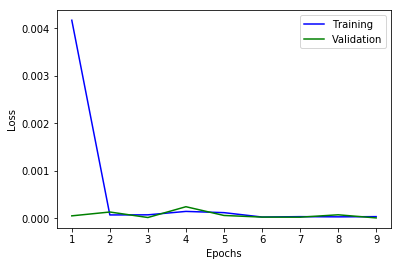

In [47]:
plot_loss_vs_epochs(history.history['loss'], history.history['val_loss'])

In [48]:
history.history

{'loss': [0.0041679317074278946,
  6.9418001682907914e-05,
  7.160443370138084e-05,
  0.00014375455981928298,
  0.0001177541963601137,
  2.5508316843915437e-05,
  3.3692368253996743e-05,
  2.9079067838962479e-05,
  3.3905598158732291e-05],
 'lr': [0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.00050000002,
  0.00050000002,
  0.00050000002,
  0.00050000002],
 'val_loss': [5.0318203438319659e-05,
  0.0001310568773661567,
  1.5344998313337735e-05,
  0.00024249077647161754,
  5.8276620929740231e-05,
  2.4004332955084279e-05,
  2.2197880919240841e-05,
  7.2417983654432668e-05,
  6.7767763290213716e-06]}

/home/ubuntu/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:4: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/home/ubuntu/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/ubuntu/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")
/home/ubuntu/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:6: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elem

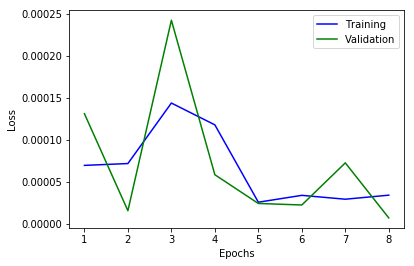

In [49]:
plot_loss_vs_epochs(history.history['loss'][1:], history.history['val_loss'][1:])